<a href="https://colab.research.google.com/github/mirkousuelli/time-series-analysis/blob/main/estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estimation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

*   <b><u>AR process (Auto Regressive)</u></b>
> $\ y(t) = a_1 y(t-1) + a_2 y(t-2) + ... + a_n y(t-n) + \eta(t) $

It uses a linear combination of past values of the target to make forecasts. Where $\eta(t)$ is a white noise. \\

Usually, autoregressive models are applied to stationary time series only. This means we will have constraints on stability such as the poles module must be contained in the stability complex disc (coefficients between 1 and -1).

\\

*   <b><u>MA process (Moving Average)</u></b>
> $\ x(t) = c_0 \eta(t) + c_1 \eta(t - 1) + ... + c_n \eta(t - n)$

Our position x(t) depends only on the weighted summation of previous noises.

\\

*   <b><u>ARMA process</u></b>
> $\ y(t) = c_0 \eta(t) + c_1 \eta(t - 1) + ... + c_n \eta(t - n) + a_1 y(t-1) + a_2 y(t-2) + ... + a_n y(t-n)$



In [ ]:
def arma_process(ar_coeff, ma_coeff, mean, std, samples):
  # generating the white noise (mean,ntd)
  e = np.random.normal(mean, std, samples)
  # starting from a pure noisy signal
  y = np.copy(e)
  # process
  for t in range(max(len(ar_coeff), len(ma_coeff)), samples):
    # AR() model
    order = 1
    for ar in ar_coeff:
      y[t] += ar * y[t - order]
      order += 1
    # MA() model
    order = 1
    for ma in ma_coeff:
      y[t] += ma * e[t - order]
      order += 1
  # returning the model
  return y

## Estimators

### Properties


1.   <b>Correctness</b>: is the estimator unbiased?

  1.   <u>Unbiased</u> : $E[\hat{x}(t)]=x(t)$ \\
  the estimator is unbiased if the estimations are spread around the true value and its expected value corresponds to the exact value
  2.   <u>Asymptotically unbiased</u> : $E[\hat{x}(t)]\rightarrow x(t)$ for $N \rightarrow \infty$


2.   <b>Consistency</b>: is the estimator consistent? \\
 $E[(\gamma_y(\tau)-\hat{\gamma}_y(\tau))^2]\rightarrow0$ for $N\rightarrow\infty$ \\
Consistency ensures that the dispersion of the estimator around the true value is decreasing with the increasing of the number of samples N.



---



Let's apply an example for the following estimators:

> $\ y(t) = \frac{1}{2}y(t-1) + e(t) - e(t-1)$  \\

with $\ e(t) \sim WN(1,9)$

This process can be written by means of the delay operator, as:

> $\ y(t) = \frac{1-z^{-1}}{1-\frac{1}{2}z^{-1}}e(t) = W(t)e(t)$

The gain of the transfer function $\ W(z) $ is:


> $\ W(z = 1) = \frac{1-1}{1-\frac{1}{2}} = 0 $

so $\ E[y(t)] = 0$ also if $\ E[e(t)] = 1$


In [ ]:
# model coefficients
ar = [0.5] 
ma = [-1]
# noise params
mean = 1
std = 9
# number of samples
n = 2000
# model
y = arma_process(ar, ma, mean, std, n)

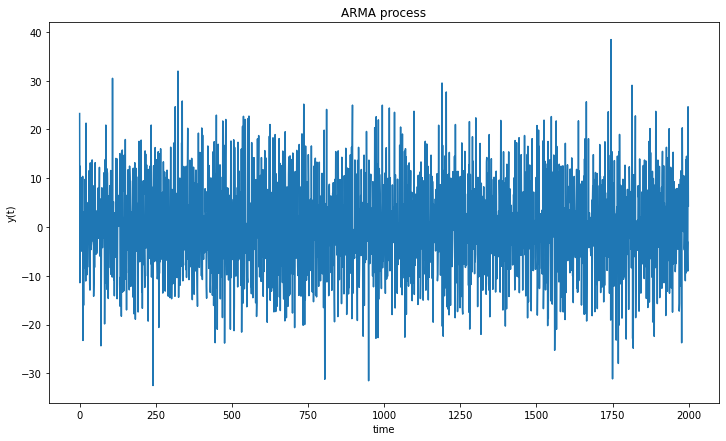

In [ ]:
# plotting
plt.figure(figsize=[12,7])
plt.plot(y)
plt.ylabel("y(t)")
plt.xlabel("time")
plt.title("ARMA process")
plt.show()

### Mean estimator

We compute the sample mean to estimate the expected value of the process $\ E[y(t)] = 0$.

In [ ]:
# mean estimator
mean_pred = np.sum(y) / n
mean_np_pred = np.mean(y)

print("mean estimator : " + str(mean_pred))
print("numpy mean estimator : " + str(mean_np_pred))

mean estimator : -0.011900432785005126
numpy mean estimator : -0.011900432785005126


#### Detrend

If the mean value were not null, by means of the function "detrend" is possible to remove the mean value from the data.

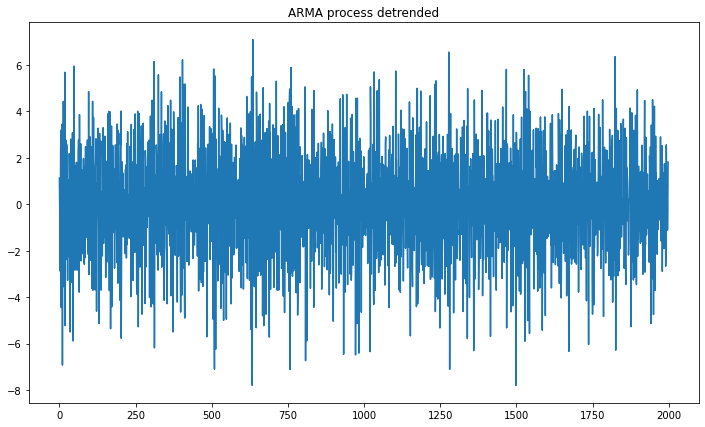


mean estimator : 0.0009826884898610708


In [ ]:
# if the model does not have a mean close to zero we can detrend it
# not necessary in this case, but explained anyway
y_detrend = [y[t] - y[t - 1] for t in range(1, len(y))]

plt.figure(figsize=[12,7])
plt.plot(y_detrend)
plt.title("ARMA process detrended")
plt.show()

# mean estimator
print("\nmean estimator : " + str(np.mean(y_detrend)))

### Covariance estimator



1.   <b><u>Method 1</u></b>


> $\ \hat{\gamma}_y(\tau)=\frac{1}{N-|\tau|}\sum_{t=1}^{N-|\tau|} y(t)y(t+|\tau|)$


2.   <b><u>Method 2</u></b>

> $\ \hat{\gamma}_y(\tau)'=\frac{1}{N}\sum_{t=1}^{N-|\tau|} y(t)y(t+|\tau|)$

3.   <b><u>Theoretical</u></b>

> $\ 
\begin{equation}
  \begin{cases}
  \gamma(0)=12\\
  \gamma(1)=-3\\
  \gamma(\tau)=\frac{1}{2}\gamma(\tau-1), \tau \ge 2
  \end{cases}
\end{equation}
$



The reliability of the estimation of the covariance function decreases with $\ \tau$, so we can consider the result for $\ \tau < N / 4$ (Box and Jenkins rule) or for $\ \tau < N / 25$ (more conservative rule).

In [ ]:
# conservative rule
cov_samples = int(n / 25)

# 1st method
def covariance_estimator_1(model, tau_samples, tot_samples):
  cov_pred = np.zeros(tau_samples + 1)
  for tau in range(0, tau_samples + 1):
    res = 0
    for t in range(1, tot_samples - tau):
      res += model[t] * model[t + tau] 
    cov_pred[tau] = res / (tot_samples - tau)
  return cov_pred

# 2nd method
def covariance_estimator_2(model, tau_samples, tot_samples):
  cov_pred = np.zeros(tau_samples + 1)
  for tau in range(0, tau_samples + 1):
    res = 0
    for t in range(1, tot_samples - tau):
      res += model[t] * model[t + tau]
    cov_pred[tau] = res / tot_samples
  return cov_pred

# covariance estimators
cov_pred_1 = covariance_estimator_1(y, cov_samples, n)
cov_pred_2 = covariance_estimator_2(y, cov_samples, n)

# theoretical method
cov_pred_3 = [12, -3]
for tau in range(2, cov_samples):
  cov_pred_3.append(0.5 * cov_pred_3[tau - 1])

For few samples it seems that there are not any differences among these methods...

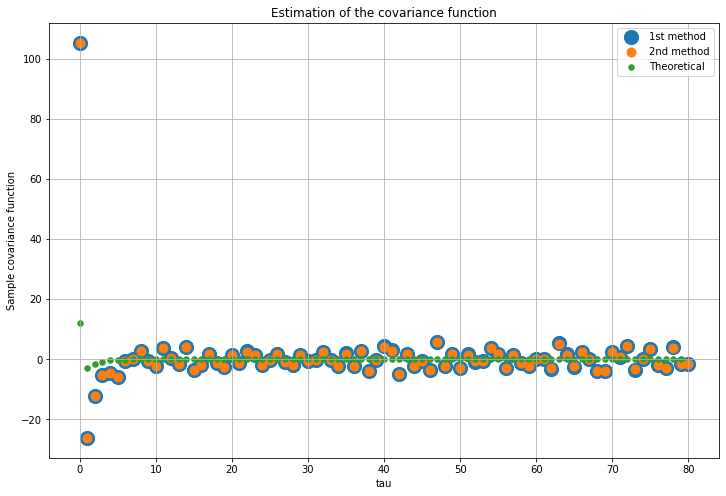

In [ ]:
# plotting
plt.figure(figsize=[12,8])
plt.scatter(range(0, len(cov_pred_1)), cov_pred_1, s=200, label='1st method')
plt.scatter(range(0, len(cov_pred_2)), cov_pred_2, s=80, label='2nd method')
plt.scatter(range(0, len(cov_pred_3)), cov_pred_3, s=30, label='Theoretical')
plt.grid()
plt.legend()
plt.xlabel('tau')
plt.ylabel('Sample covariance function')
plt.title("Estimation of the covariance function")
plt.show()

For large value of samples N, the consistent estimator (method 1) becomes unreliable.

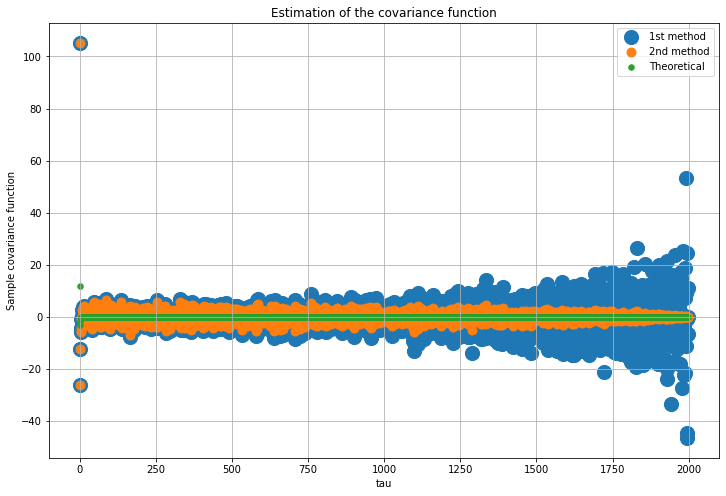

In [ ]:
# note the difference when we increase the number of samples
cov_samples = n - 1

# covariance estimators
cov_pred_1 = covariance_estimator_1(y, cov_samples, n)
cov_pred_2 = covariance_estimator_2(y, cov_samples, n)

# theoretical method
cov_pred_3 = [12, -3]
for tau in range(2, cov_samples):
  cov_pred_3.append(0.5 * cov_pred_3[tau - 1])

# plotting
plt.figure(figsize=[12,8])
plt.scatter(range(0, len(cov_pred_1)), cov_pred_1, s=200, label='1st method')
plt.scatter(range(0, len(cov_pred_2)), cov_pred_2, s=80, label='2nd method')
plt.scatter(range(0, len(cov_pred_3)), cov_pred_3, s=30, label='Theoretical')
plt.grid()
plt.legend()
plt.xlabel('tau')
plt.ylabel('Sample covariance function')
plt.title("Estimation of the covariance function")
plt.show()

### Spectrum estimator

Using the Fast Fourier Transform:

> $\ \hat{\Gamma}_y(\omega)'=\frac{1}{N}|FFT(y(t))|^2$



In [ ]:
# fast fourier transformation for real values
fourier_transform = np.fft.rfft(y)
# absolute value
abs_fourier_transform = np.abs(fourier_transform)
# spectrum estimator
spectrum_pred = np.square(abs_fourier_transform) / n

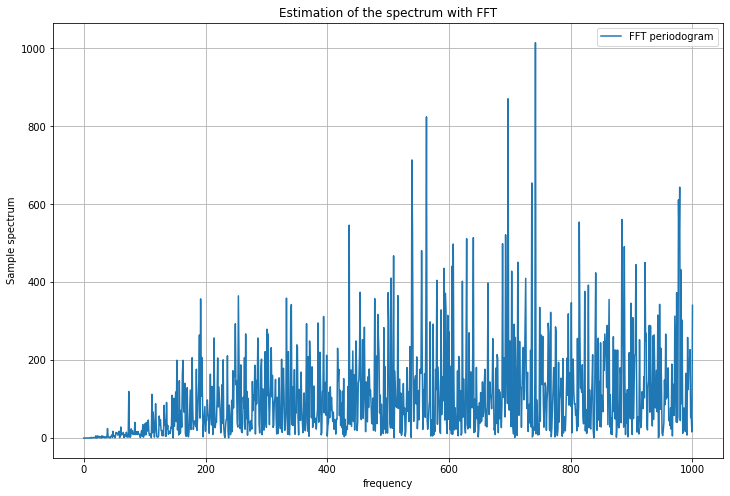

In [ ]:
# plotting
plt.figure(figsize=[12,8])
plt.plot(spectrum_pred, label="FFT periodogram")
plt.grid()
plt.legend()
plt.xlabel('frequency')
plt.ylabel('Sample spectrum')
plt.title("Estimation of the spectrum with FFT")
plt.show()

## Whiteness Anderson Test

<u>Problem</u> : How to check if a signal $y(t)$ is a white noise? \\

<u>Idea</u> : Considering the normalized sample covariance function


> $ \hat{\rho}(\tau)=\frac{\hat{\gamma}_y(\tau)}{\hat{\gamma}_y(0)} $



> $\ \hat{\gamma}_y(\tau)=\frac{1}{N-|\tau|}\sum_{t=1}^{N-|\tau|} y(t)y(t+|\tau|)$

If the process generating $y(t)$ is a white noise then, for $\tau>0$ (and for N >> 0): \\
$\hat{\rho}(\tau)$ has a probability distribution that tends to a Gaussian with zero mean and variance 1/N.

In other words, $\sqrt{N}\hat{\rho}(\tau)\sim Gauss(0,1), \forall\tau>0$




### Procedure


1.   Compute $\sqrt{N}\hat{\rho}(\tau), \tau = 1,2,...,M$ with $M << N-1$

2.   Choose a confidence level $\alpha$  in the interval (0,1), e.g. 0.05

3.   Find the value $\beta$ such that $Pr(|x| > \beta) = \alpha$, where $x \sim Gauss(0,1)$, e.g. 1.96

4.   Count the number P of values of $\sqrt{N}\hat{\rho}(\tau)$ which lies outside the interval $[-\beta, \beta]$

If $P > \alpha M \rightarrow y(t)$ is not a white noise \\
If $P \le \alpha M \rightarrow y(t)$ is a white noise 


Let's consider the MA(3) process:


> $y(t) = e(t) + 0.2e(t-1) - 0.1e(t-2)-0.5e(t-3)$
with $e(t) \sim WN(0,1)$

$N = 2000; M=30; \alpha = 0.05; \beta = 1.96$



In [ ]:
# whitness anderson test parameters
n = 2000
m = 30
alpha = 0.05 # confidence interval
beta = 1.96
# process parameters
ar = []
ma = [0.2, -0.1, -0.5]
mean = 0
std = 1
# model
y = arma_process(ar, ma, mean, std, n)

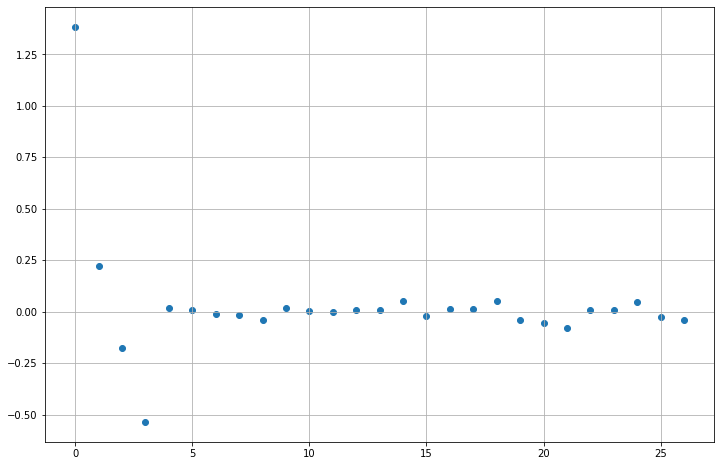

In [ ]:
cov_samples = int(n / 75)
cov_pred = covariance_estimator_1(y, cov_samples, n)
rho_pred = cov_pred / covariance_estimator_1(y, 0, n)
rho_norm = np.sqrt(n) * rho_pred

plt.figure(figsize=[12,8])
plt.scatter(range(0, len(cov_pred)), cov_pred)
plt.grid()
plt.show()

The process is clearly not a white noise:

In [ ]:
p = sum(x > beta or x < -beta for x in rho_norm)

print("alpha * m : " + str(alpha * m))
print("p : " + str(p))
print("=> the process is " + ("not" if (p > alpha * m) else "") + " a white noise")

alpha * m : 1.5
p : 5
=> the process is not a white noise


Now let's try a pure white noise:

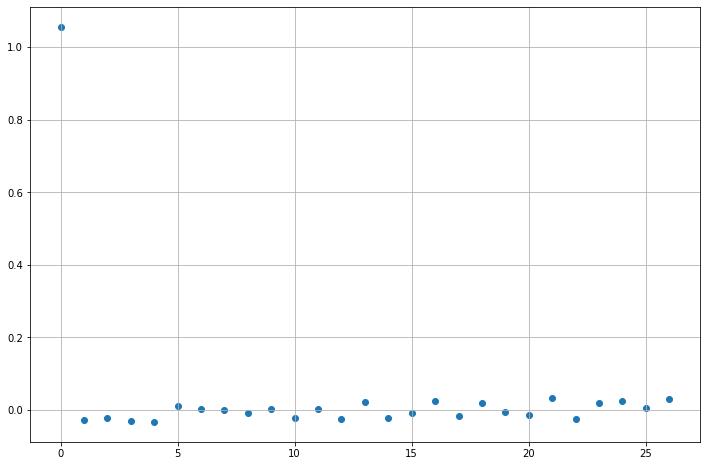


alpha * m : 1.5
p : 1
=> the process is  a white noise


In [ ]:
e = np.random.normal(0, 1, n)

cov_samples = int(n / 75)
cov_pred = covariance_estimator_1(e, cov_samples, n)
rho_pred = cov_pred / covariance_estimator_1(e, 0, n)
rho_norm = np.sqrt(n) * rho_pred

plt.figure(figsize=[12,8])
plt.scatter(range(0, len(cov_pred)), cov_pred)
plt.grid()
plt.show()

p = sum(x > beta or x < -beta for x in rho_norm)

print("\nalpha * m : " + str(alpha * m))
print("p : " + str(p))
print("=> the process is " + ("not" if (p > alpha * m) else "") + " a white noise")

## Homework

Analyse the MA(3) process:


> $y(t)=e(t)+\frac{1}{2}e(t-1)-\frac{1}{2}e(t-2)+\frac{3}{2}e(t-3)$

Compute the estimators of:


*   Average value
*   Covariance function
*   Spectrum




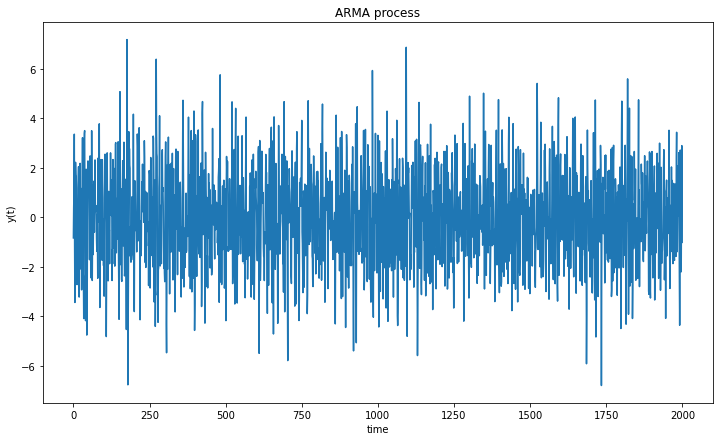

In [ ]:
# parameters
n = 2000
mean = 0
std = 1
ar = []
ma = [0.5, -0.5, -1.5]

# model
y = arma_process(ar, ma, mean, std, n)

# plotting
plt.figure(figsize=[12,7])
plt.plot(y)
plt.ylabel("y(t)")
plt.xlabel("time")
plt.title("ARMA process")
plt.show()

### Mean estimator

In [ ]:
# mean estimator
mean_pred = np.sum(y) / n
mean_np_pred = np.mean(y)

print("mean estimator : " + str(mean_pred))
print("numpy mean estimator : " + str(mean_np_pred))

mean estimator : -0.006659544678847266
numpy mean estimator : -0.006659544678847266


### Covariance estimator

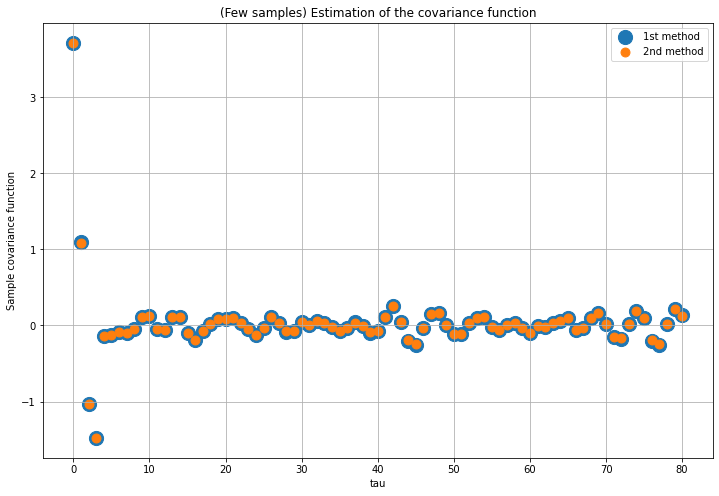

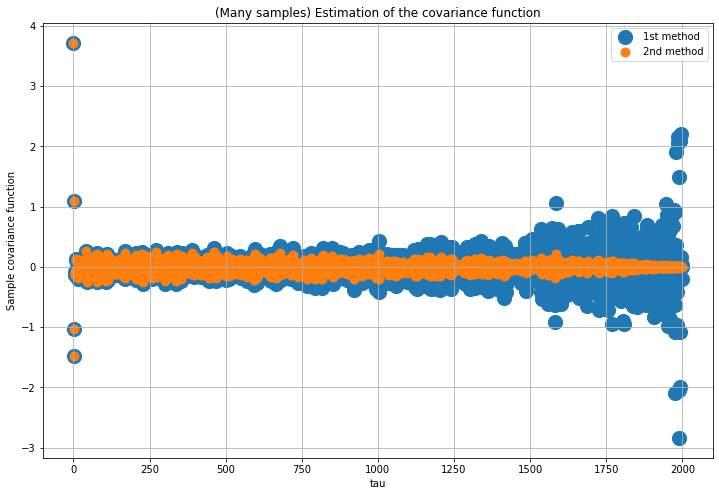

In [ ]:
''' few samples '''

cov_samples = int(n / 25)

# covariance estimators
cov_pred_1 = covariance_estimator_1(y, cov_samples, n)
cov_pred_2 = covariance_estimator_2(y, cov_samples, n)

# plotting
plt.figure(figsize=[12,8])
plt.scatter(range(0, len(cov_pred_1)), cov_pred_1, s=200, label='1st method')
plt.scatter(range(0, len(cov_pred_2)), cov_pred_2, s=80, label='2nd method')
plt.grid()
plt.legend()
plt.xlabel('tau')
plt.ylabel('Sample covariance function')
plt.title("(Few samples) Estimation of the covariance function")
plt.show()

''' many samples '''

cov_samples = n - 1

# covariance estimators
cov_pred_1 = covariance_estimator_1(y, cov_samples, n)
cov_pred_2 = covariance_estimator_2(y, cov_samples, n)

# plotting
plt.figure(figsize=[12,8])
plt.scatter(range(0, len(cov_pred_1)), cov_pred_1, s=200, label='1st method')
plt.scatter(range(0, len(cov_pred_2)), cov_pred_2, s=80, label='2nd method')
plt.grid()
plt.legend()
plt.xlabel('tau')
plt.ylabel('Sample covariance function')
plt.title("(Many samples) Estimation of the covariance function")
plt.show()

### Spectrum estimator

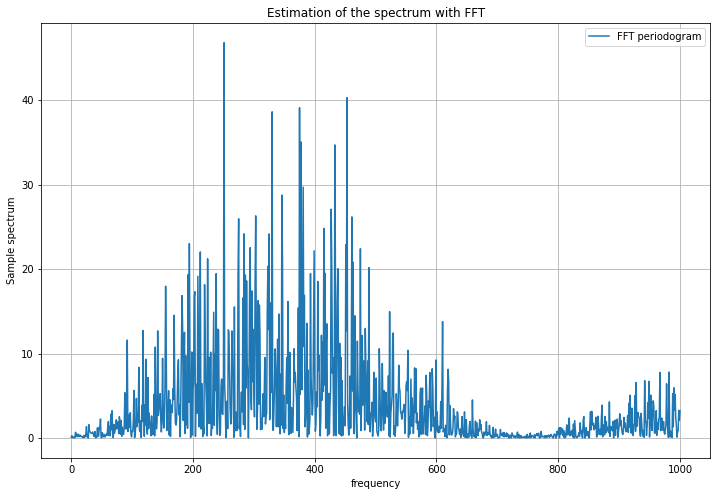

In [ ]:
# fast fourier transformation for real values
fourier_transform = np.fft.rfft(y)
# absolute value
abs_fourier_transform = np.abs(fourier_transform)
# spectrum estimator
spectrum_pred = np.square(abs_fourier_transform) / n

# plotting
plt.figure(figsize=[12,8])
plt.plot(spectrum_pred, label="FFT periodogram")
plt.grid()
plt.legend()
plt.xlabel('frequency')
plt.ylabel('Sample spectrum')
plt.title("Estimation of the spectrum with FFT")
plt.show()